# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [1]:
import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Total number of reviews: 1000

Dataset shape: (1000, 2)

Percentage of reviews that liked the restaurant: 50.00%


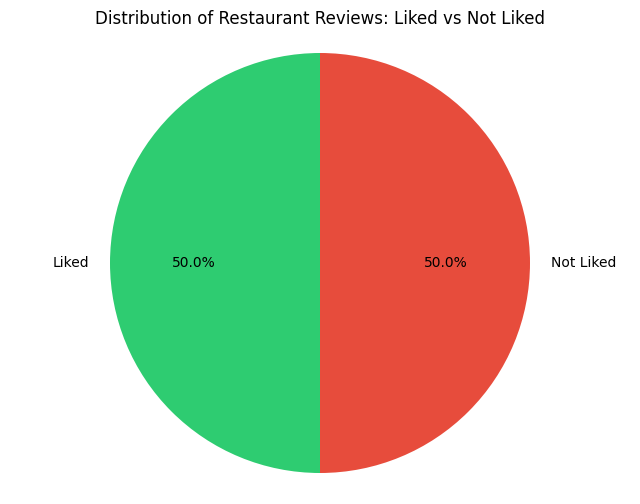

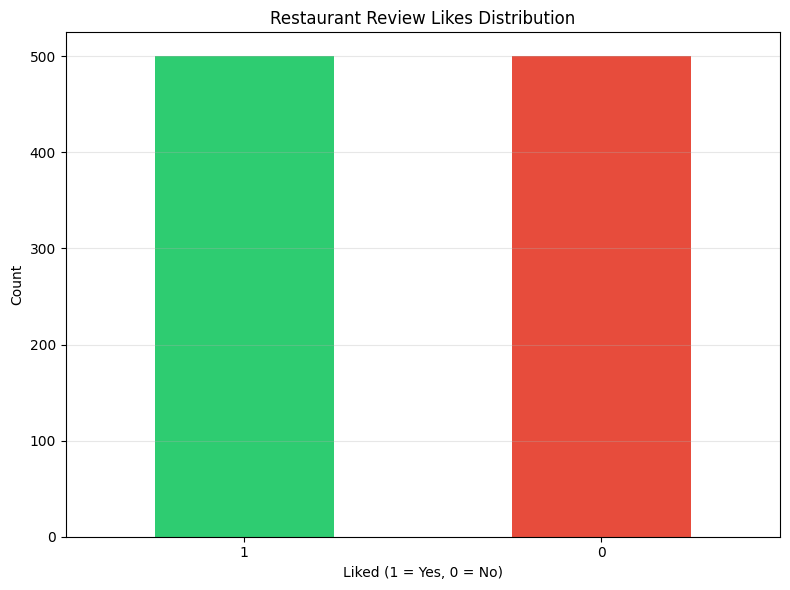

In [2]:
# Add code here

# Verify the number of rows
print(f"Total number of reviews: {len(df)}")
print(f"\nDataset shape: {df.shape}")

# Calculate the overall percentage of reviews that "Liked" the restaurant
liked_percentage = (df['Liked'].sum() / len(df)) * 100
print(f"\nPercentage of reviews that liked the restaurant: {liked_percentage:.2f}%")

# Create a visualization to show the percentage of likes versus non-likes
import matplotlib.pyplot as plt

liked_counts = df['Liked'].value_counts()
labels = ['Liked', 'Not Liked']
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(8, 6))
plt.pie(liked_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Restaurant Reviews: Liked vs Not Liked')
plt.axis('equal')
plt.show()

# Bar chart alternative
plt.figure(figsize=(8, 6))
liked_counts.plot(kind='bar', color=colors)
plt.title('Restaurant Review Likes Distribution')
plt.xlabel('Liked (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


In [3]:
# Add code here

import re

# Change all reviews to lowercase
df['Review_Clean'] = df['Review'].str.lower()

# Remove URLs and anything that isn't a regular character or number
df['Review_Clean'] = df['Review_Clean'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))
df['Review_Clean'] = df['Review_Clean'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

# Remove extra whitespace
df['Review_Clean'] = df['Review_Clean'].apply(lambda x: ' '.join(x.split()))

# Display sample of cleaned reviews
print("Original vs Cleaned Reviews (first 5):")
print("="*80)
for i in range(5):
    print(f"\nOriginal: {df['Review'].iloc[i]}")
    print(f"Cleaned:  {df['Review_Clean'].iloc[i]}")
    print("-"*80)

Original vs Cleaned Reviews (first 5):

Original: Wow... Loved this place.
Cleaned:  wow loved this place
--------------------------------------------------------------------------------

Original: Crust is not good.
Cleaned:  crust is not good
--------------------------------------------------------------------------------

Original: Not tasty and the texture was just nasty.
Cleaned:  not tasty and the texture was just nasty
--------------------------------------------------------------------------------

Original: Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
Cleaned:  stopped by during the late may bank holiday off rick steve recommendation and loved it
--------------------------------------------------------------------------------

Original: The selection on the menu was great and so were the prices.
Cleaned:  the selection on the menu was great and so were the prices
------------------------------------------------------------------------

### ✍️ Your Response: 🔧
1. Including review "junk" could introduce noise and reduce model accuracy. URLs, emojis, and punctuation don't carry meaningful semantic information for topic modeling but would be treated as features, diluting the importance of actual content words. This could lead to misclassification, inflated vocabulary size, poor topic coherence, and difficulty in interpreting results.

## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment Distribution:
Positive: 50.30%
Negative: 25.50%
Neutral: 24.20%


Comparison: Sentiment vs Liked
Liked (1): 50.00%
Not Liked (0): 50.00%

Positive Sentiment: 50.30%
Negative Sentiment: 25.50%
Neutral Sentiment: 24.20%


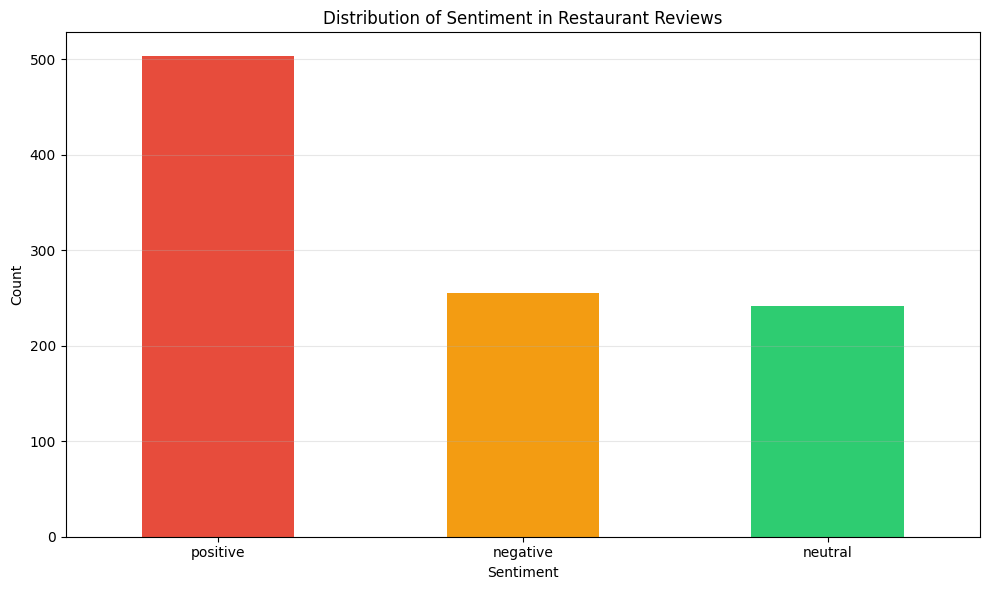

In [5]:
# Add code here

# Use NLTK's VADER (already used in lab 13)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download vader_lexicon if needed
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['compound_score'] = df['Review_Clean'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify sentiment based on compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['compound_score'].apply(classify_sentiment)

# Calculate percentage of each sentiment
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100

print("Sentiment Distribution:")
print("="*50)
for sentiment, percentage in sentiment_percentages.items():
    print(f"{sentiment.capitalize()}: {percentage:.2f}%")

# Compare sentiment to Liked
liked_percentage = (df['Liked'].sum() / len(df)) * 100
print("\n\nComparison: Sentiment vs Liked")
print("="*50)
print(f"Liked (1): {liked_percentage:.2f}%")
print(f"Not Liked (0): {100 - liked_percentage:.2f}%")
print(f"\nPositive Sentiment: {sentiment_percentages.get('positive', 0):.2f}%")
print(f"Negative Sentiment: {sentiment_percentages.get('negative', 0):.2f}%")
print(f"Neutral Sentiment: {sentiment_percentages.get('neutral', 0):.2f}%")

# Visualize sentiment distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['#e74c3c', '#f39c12', '#2ecc71'])
plt.title('Distribution of Sentiment in Restaurant Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### ✍️ Your Response: 🔧
1. The sentiment analysis reveals a more nuanced picture than the binary "Liked" metric. While 50% of reviews are marked as "Liked," sentiment analysis shows 50.30% positive, 25.50% negative, and 24.20% neutral. This indicates that the "Liked" variable closely aligns with positive sentiment, but sentiment analysis captures additional gradations that the binary metric misses, particularly distinguishing between neutral and negative experiences.

2. From a restaurant owner's perspective, negative sentiment reviews are most important to analyze. These reviews (25.50%) identify specific problems and pain points that need immediate attention. While positive reviews validate what's working and neutral reviews may indicate average experiences, negative reviews provide actionable insights for improvement and represent customers at risk of not returning or leaving poor ratings online.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


In [7]:
# Add code here

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download all necessary NLTK corpora
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess function
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    processed_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:  # Remove short words
            lemmatized = lemmatizer.lemmatize(token)
            processed_tokens.append(lemmatized)

    return processed_tokens

# Apply preprocessing
df['processed_tokens'] = df['Review_Clean'].apply(preprocess_text)

# Display first 10 processed reviews
print("First 10 Processed Reviews:")
print("="*80)
for i in range(10):
    print(f"\nReview {i+1}:")
    print(f"Original: {df['Review'].iloc[i]}")
    print(f"Tokens: {df['processed_tokens'].iloc[i]}")
    print("-"*80)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


First 10 Processed Reviews:

Review 1:
Original: Wow... Loved this place.
Tokens: ['wow', 'loved', 'place']
--------------------------------------------------------------------------------

Review 2:
Original: Crust is not good.
Tokens: ['crust', 'good']
--------------------------------------------------------------------------------

Review 3:
Original: Not tasty and the texture was just nasty.
Tokens: ['tasty', 'texture', 'nasty']
--------------------------------------------------------------------------------

Review 4:
Original: Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
Tokens: ['stopped', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'loved']
--------------------------------------------------------------------------------

Review 5:
Original: The selection on the menu was great and so were the prices.
Tokens: ['selection', 'menu', 'great', 'price']
-----------------------------------------------------------------

### ✍️ Your Response: 🔧
1. A corpora (plural: corpora) is a large collection of texts used for linguistic analysis. In text analytics, corpora provide the language data needed to train models, identify patterns, and understand word usage in context. NLTK corpora include pre-labeled datasets like stopwords, which help filter out common words that don't contribute meaningful information.

2. After preprocessing, the tokens in "Wow… Loved this place." would be: ['wow', 'loved', 'place']. The stopwords and punctuation are removed, leaving only the meaningful content words.


3. Lemmatization reduces words to their base or dictionary form (lemma). For example, "running," "runs," and "ran" all become "run." This helps by consolidating different forms of the same word, reducing vocabulary size, improving topic coherence, and ensuring that variations of words are treated as the same concept rather than separate features.

## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

In [9]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 62.5 MB/s eta 0:00:00


In [10]:
# Add code here

from gensim.corpora import Dictionary
from gensim import corpora

# Create dictionary
dictionary = Dictionary(df['processed_tokens'])

# Filter extremes (optional but recommended)
dictionary.filter_extremes(no_below=2, no_above=0.5)

# Create corpus (bag of words)
corpus = [dictionary.doc2bow(tokens) for tokens in df['processed_tokens']]

# Display summary
print("Dictionary Summary:")
print("="*50)
print(f"Number of unique tokens: {len(dictionary)}")
print(f"\nFirst 10 tokens in dictionary:")
for i in range(min(10, len(dictionary))):
    print(f"  ID {i}: {dictionary[i]}")

print("\n\nCorpus Summary:")
print("="*50)
print(f"Number of documents: {len(corpus)}")
print(f"\nFirst document in corpus (word_id, frequency):")
print(corpus[0][:10])  # Show first 10 word-frequency pairs

# Show example of how corpus represents a document
print("\n\nExample: First Review Representation")
print("="*50)
print(f"Original review: {df['Review'].iloc[0]}")
print(f"Processed tokens: {df['processed_tokens'].iloc[0]}")
print(f"Corpus representation: {corpus[0]}")

Dictionary Summary:
Number of unique tokens: 730

First 10 tokens in dictionary:
  ID 0: loved
  ID 1: place
  ID 2: wow
  ID 3: crust
  ID 4: good
  ID 5: nasty
  ID 6: tasty
  ID 7: texture
  ID 8: late
  ID 9: may


Corpus Summary:
Number of documents: 1000

First document in corpus (word_id, frequency):
[(0, 1), (1, 1), (2, 1)]


Example: First Review Representation
Original review: Wow... Loved this place.
Processed tokens: ['wow', 'loved', 'place']
Corpus representation: [(0, 1), (1, 1), (2, 1)]


### ✍️ Your Response: 🔧
1. A corpus (plural: corpora) in this context is a collection of documents represented as bag-of-words vectors. Each document is a list of (word_id, frequency) tuples showing which words appear and how often. This numerical representation is essential for LDA because machine learning models require numerical input rather than raw text.

2. A dictionary maps words to unique integer IDs, serving as a vocabulary reference (e.g., "food" = ID 5). A corpus uses this dictionary to represent documents as vectors of (word_id, frequency) pairs. The dictionary is the vocabulary lookup table, while the corpus is the actual data representation of all documents using those IDs.

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


In [11]:
# Add code here

from gensim.models import LdaModel
import warnings
warnings.filterwarnings('ignore')

# Set number of topics
num_topics = 5

# Build LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    iterations=100,
    per_word_topics=True
)

print("LDA Model Training Complete!")
print("="*50)
print(f"Number of topics: {num_topics}")
print(f"Number of documents: {len(corpus)}")
print(f"Dictionary size: {len(dictionary)}")

# Display topics with top words
print("\n\nTopics and Top Words:")
print("="*50)
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"\nTopic {idx}:")
    print(topic)

LDA Model Training Complete!
Number of topics: 5
Number of documents: 1000
Dictionary size: 730


Topics and Top Words:

Topic 0:
0.054*"food" + 0.052*"good" + 0.034*"great" + 0.030*"time" + 0.021*"service" + 0.017*"back" + 0.013*"place" + 0.013*"friendly" + 0.012*"bad" + 0.011*"best"

Topic 1:
0.024*"back" + 0.016*"place" + 0.015*"disappointed" + 0.014*"service" + 0.013*"great" + 0.012*"wont" + 0.012*"pizza" + 0.011*"delicious" + 0.011*"dish" + 0.011*"experience"

Topic 2:
0.040*"place" + 0.033*"food" + 0.025*"like" + 0.015*"never" + 0.011*"also" + 0.011*"one" + 0.011*"burger" + 0.011*"amazing" + 0.011*"much" + 0.011*"restaurant"

Topic 3:
0.030*"place" + 0.027*"good" + 0.020*"service" + 0.017*"great" + 0.015*"star" + 0.015*"really" + 0.015*"pretty" + 0.014*"chicken" + 0.014*"could" + 0.012*"like"

Topic 4:
0.036*"service" + 0.020*"worst" + 0.016*"back" + 0.015*"slow" + 0.014*"perfect" + 0.014*"dont" + 0.013*"ever" + 0.013*"terrible" + 0.011*"probably" + 0.010*"nothing"


### ✍️ Your Response: 🔧
1. You would want more than 5 topics when dealing with larger, more diverse datasets covering multiple distinct themes. For example, a dataset with reviews from multiple restaurant types (fast food, fine dining, cafes) or covering many different aspects (food quality, service, ambiance, pricing, location) would benefit from 7-10+ topics to capture the full range of themes.


2. You have too many topics when they start becoming redundant or incoherent—meaning multiple topics share very similar words, topics contain unrelated words grouped together, or topics are too specific to be meaningful. Signs include low coherence scores, difficulty interpreting topic meanings, and topics with very few documents assigned to them.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"


Topics and Top 10 Words:

Topic 0:
  Words: food, good, great, time, service, back, place, friendly, bad, best
  Details: [('food', np.float32(0.054090615)), ('good', np.float32(0.05201631)), ('great', np.float32(0.033502124)), ('time', np.float32(0.030272132)), ('service', np.float32(0.020527381)), ('back', np.float32(0.016706718)), ('place', np.float32(0.012733285)), ('friendly', np.float32(0.012599391)), ('bad', np.float32(0.011788687)), ('best', np.float32(0.011197474))]

Topic 1:
  Words: back, place, disappointed, service, great, wont, pizza, delicious, dish, experience
  Details: [('back', np.float32(0.024301184)), ('place', np.float32(0.015704818)), ('disappointed', np.float32(0.014850117)), ('service', np.float32(0.014425583)), ('great', np.float32(0.012856501)), ('wont', np.float32(0.012024289)), ('pizza', np.float32(0.011969697)), ('delicious', np.float32(0.011312815)), ('dish', np.float32(0.011261312)), ('experience', np.float32(0.011031938))]

Topic 2:
  Words: place, food

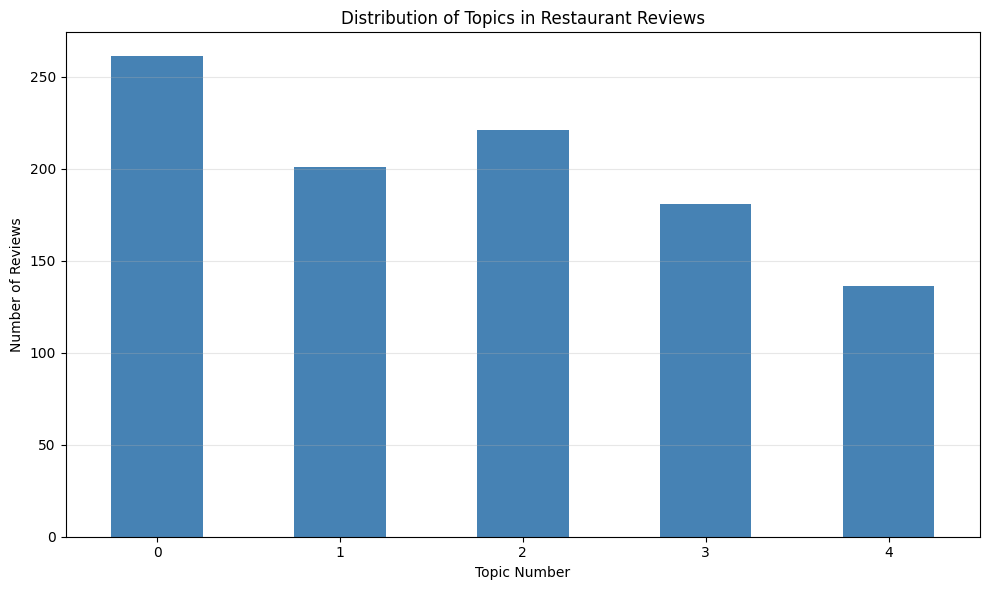

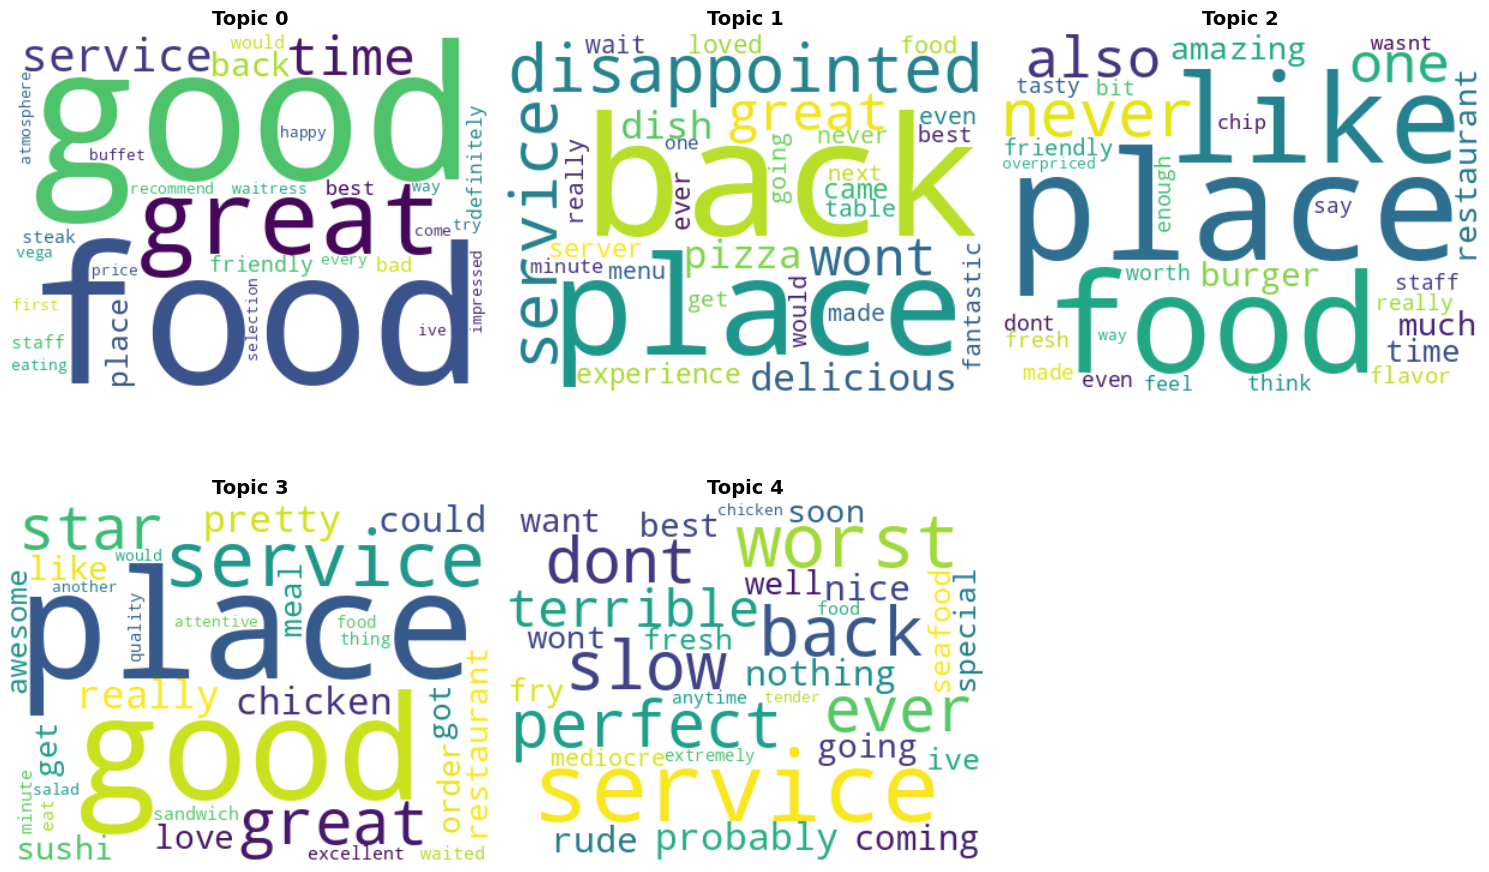



Sentiment by Topic:

Topic 0 (n=261):
  Positive: 60.92%
  Neutral: 20.31%
  Negative: 18.77%

Topic 1 (n=201):
  Positive: 46.27%
  Neutral: 29.35%
  Negative: 24.38%

Topic 2 (n=221):
  Positive: 47.51%
  Neutral: 25.79%
  Negative: 26.70%

Topic 3 (n=181):
  Positive: 54.14%
  Neutral: 19.89%
  Negative: 25.97%

Topic 4 (n=136):
  Positive: 35.29%
  Neutral: 27.21%
  Negative: 37.50%


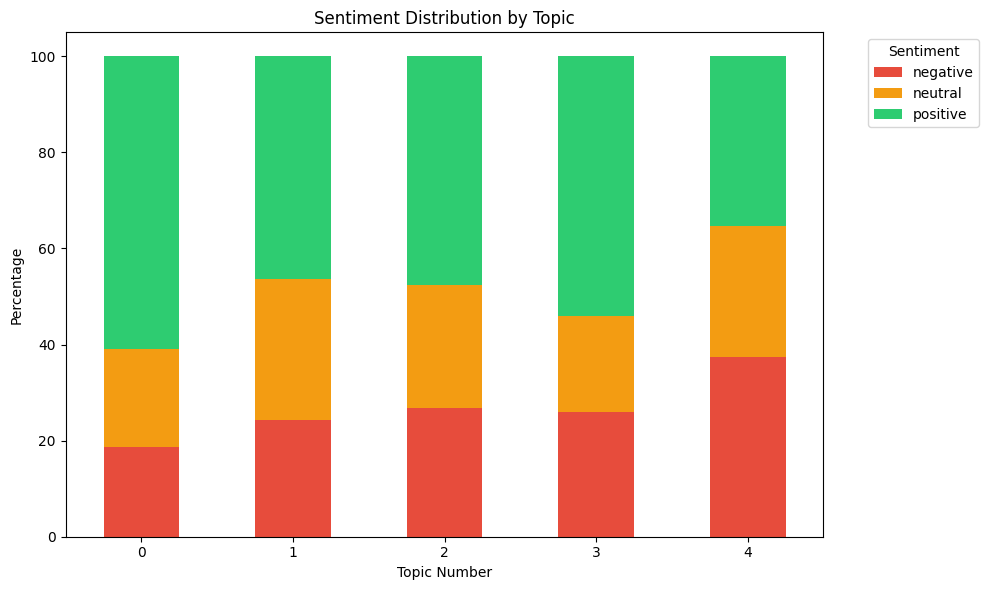

In [12]:
# Add code here

import numpy as np
from collections import Counter
from wordcloud import WordCloud

# Print topics with top 10 words
print("Topics and Top 10 Words:")
print("="*80)
for idx in range(num_topics):
    topic_words = lda_model.show_topic(idx, topn=10)
    print(f"\nTopic {idx}:")
    words = [word for word, prob in topic_words]
    print(f"  Words: {', '.join(words)}")
    print(f"  Details: {topic_words}")

# Get dominant topic for each review
def get_dominant_topic(bow):
    topic_dist = lda_model.get_document_topics(bow)
    if topic_dist:
        return max(topic_dist, key=lambda x: x[1])[0]
    return -1

df['dominant_topic'] = [get_dominant_topic(doc) for doc in corpus]

# Calculate frequency of each topic
topic_counts = df['dominant_topic'].value_counts().sort_index()
print("\n\nTopic Frequency:")
print("="*50)
for topic, count in topic_counts.items():
    if topic >= 0:
        percentage = (count / len(df)) * 100
        print(f"Topic {topic}: {count} reviews ({percentage:.2f}%)")

# Visualize topic distribution
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='steelblue')
plt.title('Distribution of Topics in Restaurant Reviews')
plt.xlabel('Topic Number')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Create word clouds for each topic
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(num_topics):
    topic_words = dict(lda_model.show_topic(idx, topn=30))
    wordcloud = WordCloud(width=400, height=300,
                         background_color='white').generate_from_frequencies(topic_words)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Topic {idx}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Remove extra subplot
axes[5].remove()

plt.tight_layout()
plt.show()

# Summarize sentiment by topic
print("\n\nSentiment by Topic:")
print("="*80)
for topic in range(num_topics):
    topic_df = df[df['dominant_topic'] == topic]
    if len(topic_df) > 0:
        sentiment_dist = topic_df['sentiment'].value_counts()
        sentiment_pct = (sentiment_dist / len(topic_df)) * 100

        print(f"\nTopic {topic} (n={len(topic_df)}):")
        for sentiment in ['positive', 'neutral', 'negative']:
            pct = sentiment_pct.get(sentiment, 0)
            print(f"  {sentiment.capitalize()}: {pct:.2f}%")

# Visualize sentiment by topic
sentiment_by_topic = df.groupby(['dominant_topic', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_topic_pct = sentiment_by_topic.div(sentiment_by_topic.sum(axis=1), axis=0) * 100

sentiment_by_topic_pct.plot(kind='bar', stacked=True,
                            color=['#e74c3c', '#f39c12', '#2ecc71'],
                            figsize=(10, 6))
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic Number')
plt.ylabel('Percentage')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### ✍️ Your Response: 🔧
List your topics and names here:

Topic 0 - Food Quality: Words focus on food, good, great, time, best—primarily about overall food quality and dining experience

Topic 1 - Disappointment & Dishes: Centers on disappointment, pizza, dishes, experience—specific menu items and unmet expectations

Topic 2 - Place & Ambiance: Emphasizes place, never, burger, restaurant, amazing—overall venue experience and specific items

Topic 3 - Service & Ratings: Includes service, star, pretty, chicken, good—service quality and rating-related terms

Topic 4 - Poor Service: Features worst, slow, terrible, service—predominantly negative service experiences

## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
1. The model helped answer: "What are the main themes in customer feedback, and what aspects of the restaurant experience drive satisfaction or dissatisfaction?" It identified five key topics including food quality, specific dishes, ambiance, service quality, and service complaints, revealing that service issues are a critical pain point.

2. I recommend the restaurant prioritize improving service quality. Topic 4 (Poor Service) shows the highest negative sentiment (37.50%) and contains words like "worst," "slow," and "terrible." Specific actions: train staff on efficiency, reduce wait times, improve communication with customers, and implement a service recovery protocol. Additionally, address specific menu items mentioned in Topic 1's disappointment cluster.

3. Pros of LLM: Faster analysis with no coding required, can handle nuanced context better, provides natural language summaries immediately, easier for non-technical users. Cons of LLM: Less transparent/reproducible, can't process 1000+ reviews efficiently in one prompt, no quantitative metrics, expensive for large-scale analysis, potential bias in interpretation, lacks systematic statistical validation.

4. LLM Prompt: "You are a restaurant business analyst. I have 1000 customer reviews for a restaurant. Please analyze these reviews and provide: (1) The 5 main topics/themes customers discuss most frequently, (2) The sentiment (positive/negative/neutral) associated with each topic, (3) Specific actionable recommendations to improve customer satisfaction based on negative feedback patterns. Format your output as: Topic name, key words, sentiment breakdown (%), and business recommendations. Focus on identifying concrete operational issues the restaurant can address."

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [ ]:
!jupyter nbconvert --to html "assignment_11_LastnameFirstname.ipynb"